# **Simulador "2 Link Planar Robot" Sin Ruido**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from IPython.display import HTML
from scipy.integrate import solve_ivp

# la funcionalidad específica de robótica está en el toolbox
import roboticstoolbox as rtb
# spatialmath tiene define los grupos de transformaciones especiales: rotación SO3 y eculideo SE3
import spatialmath as sm
from spatialmath import SE3
import os
import time
from datetime import datetime
fecha_actual = datetime.now().strftime('%Y_%m_%d-%H_%M_%S')

In [2]:
# Extiendo la clase DHRobot para que incluya el generador de trayectorias joint y cartesiano
from roboticstoolbox import DHRobot, RevoluteDH

class DHRobotGT(DHRobot):
  def __init__(self, *args, tacc=0.1, Ts=1E-3,vmax=np.array([2*np.pi,2*np.pi]), **kwargs):
    super().__init__(*args, **kwargs)
    self.tacc = tacc #Tiempo de aceleracion
    self.Ts = Ts #Intervalo de muestreo
    self.vmax = vmax #Velocidad maxima de las aceleraciones

  def interpoladorTrapezoidal(self,A,B,C,Tj):
    #Lo necesito para los movimientos en espacio de joints, para evitar que las aceleraciones sean deltas (limitacion en torques aplicados x dinamica inversa)
    """
    Interpolador trapezoidal en zona 1 y 2

    Args:
      A: punto en el que estoy
      B: punto al que estaba yendo en el segmento anterior
      C: punto al que voy
      Tj: tiempo en que se realiza el movimiento

    Returns:
      q_aux: vector interpolado de posiciones
      qd_aux: vector interpolado de velocidades
      qdd_aux: vector interpolado de aceleraciones
    """
    DA = A-B
    DC = C-B

    # Zona 1
    # Generar el vector tseg para Zona 1 -> Zona de aceleracion
    tseg = np.arange(-self.tacc + self.Ts, self.tacc + self.Ts, self.Ts) #

    # Calculo las referencias para zona 1
    qdd_aux = np.outer((DC/Tj+DA/self.tacc)/(2*self.tacc),np.ones(len(tseg)))
    qd_aux = (DC / Tj)[:, np.newaxis] * (tseg + self.tacc) / (2 * self.tacc) + (DA / self.tacc)[:, np.newaxis] * (tseg - self.tacc) / (2 * self.tacc)
    q_aux = (DC / Tj)[:, np.newaxis] * (tseg + self.tacc)**2 / (4 * self.tacc) + (DA / self.tacc)[:, np.newaxis] * (tseg - self.tacc)**2 / (4 * self.tacc) + np.outer(B,np.ones(len(tseg)))

    # Zona 2
    # Generar el vector tseg para Zona 2
    tseg = np.arange(self.tacc + self.Ts, Tj - self.tacc + 0.5* self.Ts , self.Ts)

    # Inicializar las matrices theta2p, thetap y theta
    qdd_aux = np.hstack([qdd_aux,np.zeros((len(B), len(tseg)))])   # Suponiendo que B es un vector
    qd_aux = np.hstack([qd_aux,np.outer(DC / Tj, np.ones(len(tseg)))])
    q_aux = np.hstack([q_aux,np.outer(DC / Tj, tseg) +  np.outer(B,np.ones(len(tseg)))])
    return q_aux,qd_aux,qdd_aux

  def genTrJoint(self, q_dest,Td):
    """
    Genera la trayectoria joint para un conjunto de puntos de paso

    Args:
      q_dest: Matriz con los puntos de paso. Cada fila corresponde a un punto
      Td: tiempos deseados de cada movimiento

    Returns:
      t: Vector de tiempo de referencia
      q: Vector de posiciones articulares de referencia
      qd: Vector de velocidades articulares de referencia
      qdd: Vector de aceleraciones articulares de referencia
      POSES: Vector de posiciones cartesianas de referencia (Son las matrices A0_6 de cada posicion)
    """
    q = np.empty((self.nlinks,0)); qd = np.empty((self.nlinks,0)); qdd = np.empty((self.nlinks,0))
    A = q_dest[0,:];
    for i in range(len(q_dest)):
      B = q_dest[i,:]
      if i<len(q_dest)-1:
        C = q_dest[i+1,:]
      else:
        C = B
        Td[i] = 0
      Tj = np.max((np.max(np.abs(C-B)/self.vmax),Td[i],2*self.tacc))
      q_aux,qd_aux,qdd_aux = self.interpoladorTrapezoidal(A,B,C,Tj)
      q = np.hstack([q,q_aux]); qd = np.hstack([qd,qd_aux]); qdd = np.hstack([qdd,qdd_aux]);
      A = q[:,-1]
    t = np.linspace(0, q.shape[1],num=q.shape[1])*self.Ts

    # Calculo la trayectoria cartesiana deseada
    POSES = self.fkine(q.transpose()) # .extend([self.fkine(q[:,i]) for i in range(q.shape[1])])
    return t,q.transpose(),qd.transpose(),qdd.transpose(),POSES



  def genTrCart(self, POSE_dest, Td):
    POSEA = POSE_dest[0]
    POSES = []
    for i in range(len(POSE_dest)):
        POSEB = POSE_dest[i]
        if i < len(POSE_dest) - 1:
            POSEC = POSE_dest[i + 1]
        else:
            C = B
            #POSEC = POSEB  # Asegúrate de que POSEC no sea reutilizado incorrectamente
            Td[i] = 0

        A = np.concatenate((POSEA.t, POSEA.eulervec()))
        B = np.concatenate((POSEB.t, POSEB.eulervec()))
        C = np.concatenate((POSEC.t, POSEC.eulervec()))
        Tj = np.max([Td[i], 2 * self.tacc])

        # Realizar interpolación trapezoidal
        pos, _, _ = self.interpoladorTrapezoidal(A, B, C, Tj)
        POSES.extend([sm.SE3(pos[0:3,j])*sm.SE3.EulerVec(pos[3:,i]) for j in range(pos.shape[1])])


        # Asegurar interpolación correcta de las rotaciones
        #for j in range(pos.shape[1]):
        #    transl = pos[0:3, j]
        #    rot = sm.SE3.EulerVec(pos[3:, j])
        #    pose = sm.SE3(transl) * rot
        #    POSES.append(pose)

        POSEA = POSES[-1]

    # Resolver la cinemática inversa para todas las poses
    q = np.zeros((len(POSES), self.nlinks))
    for i in range(len(POSES)):
        q[i, :], _ = self.ikine_a(POSES[i])

    # Derivar numéricamente para obtener qd y qdd
    qd = np.diff(q, axis=0) / self.Ts
    qd = np.vstack([qd, np.zeros(self.nlinks,)])

    qdd = np.diff(qd, axis=0) / self.Ts
    qdd = np.vstack([qdd, np.zeros(self.nlinks,)])

    t = np.linspace(0, len(q), num=len(q)) * self.Ts
    return t, q, qd, qdd, POSES


In [3]:
# Preparo el modelo de un doble péndulo
class DoublePendulum(DHRobotGT):
  def __init__(self, L1, L2, m1, m2, xg1, xg2, Ig1, Ig2, B1=1, B2=1, G1=1, G2=1, *args,**kwargs):
    # Definición de los enlaces usando parámetros DH
    eje1 = RevoluteDH(a=L1,alpha=0,m=m1,
            r=np.array([xg1, 0, 0]),
            I=np.array([0,0,0,0,0,0,0,0,Ig1]),
            B=B1, G=G1)
    eje2 = RevoluteDH(a=L2,alpha=0,m=m2,
            r=np.array([xg2, 0, 0]),
            I=np.array([0,0,0,0,0,0,0,0,Ig2]),
            B=B2, G=G2)
    
    eje1 = eje1.nofriction()
    eje2 = eje2.nofriction()
    self.link_lengths = [L1, L2]

    # Crear la estructura del robot
    super().__init__(*args,[eje1, eje2], name='DoublePendulum',gravity = np.array([0, -9.8, 0]),**kwargs)

  def ikine_a(self, POSE, conf=1): #La cinematica inversa no esta planteada de forma analitica https://petercorke.github.io/robotics-toolbox-python/IK/ik.html#ik
    """
    Cinemática inversa analítica

    Args:
      POSE: Posición y orientación en el espacio
      config: configuración del codo (-1 ó 1)

    Returns:
      q: Posiciones articulares
      status: Estado del algoritmo de cálculo (<0 es error)
    """
    conf = 1 if conf >= 0 else -1

    q = np.zeros((2,));
    px, py, pz = POSE.t
    a1 = self.links[0].a
    a2 = self.links[1].a

    if (px**2+py**2)>(a1+a2)**2:
      status = -1;
      print(f"El punto ({px:.2f},{py:.2f}) no es alcanzable");
    elif (px**2+py**2)<1E-10:
      status = 0;
      q[0] = 0;
      q[1] = np.pi;
    else:
      c2 = (px**2+py**2-(a1**2+a2**2))/(2*a1*a2);
      s2 = conf * math.sqrt(1-c2**2);
      q[1] = math.atan2(s2,c2);

      s1 = (a2*(py*c2-px*s2)+a1*py)/(px**2+py**2);
      c1 = (a2*(py*s2+px*c2)+a1*px)/(px**2+py**2);
      q[0] = math.atan2(s1,c1);
      status = 0;
    return q,status
  
  def fkine_matrixes(self, set_qs):
    #fkines = self.fkine_all(q=set_qs)
    #fkinemat = []
    #for item in range(len(fkines)):
    #    fkinemat.append(np.matrix(fkines[item]))
    #return fkinemat
    #return [np.matrix(fk) for fk in self.fkine_all(q=set_qs)]
    return [np.array(fk.A) for fk in self.fkine_all(q=set_qs)]


  def show(self, set_qs):
      fkinemat = self.fkine_matrixes(set_qs)
      #Posiciones de los joints en 2D (en [x,y])
      joint1_position = fkinemat[1][0:3,3].flatten()
      joint2_position = fkinemat[2][0:3,3].flatten()
      # Print positions for debugging
      print("Joint 1 Position:", joint1_position)
      print("Joint 2 Position:", joint2_position)
      # Plot the robot
      fig, ax = plt.subplots()
      # Plot links
      ax.plot([0, joint1_position[0], joint2_position[0]],
              [0, joint1_position[1], joint2_position[1]], 'bo-')
      # Plot joints
      ax.plot(0, 0, 'ro')  # Base joint
      ax.plot(joint1_position[0], joint1_position[1], 'ro')  # Joint 1
      ax.plot(joint2_position[0], joint2_position[1], 'ro')  # Joint 2
      # Set axis limits
      ax.set_xlim([-(1.5)*self.link_lengths[0] - self.link_lengths[1] , (1.5)*self.link_lengths[0] + self.link_lengths[1]])
      ax.set_ylim([-(1.5)*self.link_lengths[0] - self.link_lengths[1] , (1.5)*self.link_lengths[0] + self.link_lengths[1]])
      # Set aspect ratio to equal
      ax.set_aspect('equal', adjustable='box')
      ax.grid()

      plt.show()
      #plt.close(fig)
      return #fig  
  

  def show_animation(self, trajectory, total_time, tcp_trajectory=None):
      fig, ax = plt.subplots()
      frames = len(trajectory)
      interval = (total_time * 1000) / frames

      def update(frame):
          ax.clear()
          # Set axis limits
          ax.set_xlim([-(1.5)*self.link_lengths[0] - self.link_lengths[1] , (1.5)*self.link_lengths[0] + self.link_lengths[1]])
          ax.set_ylim([-(1.5)*self.link_lengths[0] - self.link_lengths[1] , (1.5)*self.link_lengths[0] + self.link_lengths[1]])
          # Set aspect ratio to equal
          ax.set_aspect('equal', adjustable='box')
          ax.grid()

          # Plot the trajectory
          if tcp_trajectory is not None:
            ax.plot([pose[0] for pose in tcp_trajectory[:frame+1]], [pose[1] for pose in tcp_trajectory[:frame+1]], 'k--', label='TCP Trajectory')
          # Plot the robot at the current configuration
          #self.set_joint_angles(*trajectory[frame]
          fkinemat = self.fkine_matrixes(set_qs=trajectory[frame])
          #Posiciones de los joints en 2D (en [x,y])
          joint1_position = fkinemat[1][0:3,3].flatten()
          joint2_position = fkinemat[2][0:3,3].flatten()

          ax.plot([0, joint1_position[0], joint2_position[0]],
                  [0, joint1_position[1], joint2_position[1]], 'bo-')

          ax.plot(0, 0, 'ro')  # Base joint
          ax.plot(joint1_position[0], joint1_position[1], 'ro')  # Joint 1
          ax.plot(joint2_position[0], joint2_position[1], 'ro')  # Joint 2

      # Animar al robot a lo largo de la trayectoria segun el numero de pasos
      ani = FuncAnimation(fig, update, frames=frames, interval=interval) #interval

      # Para mostrar la simulación
      #plt.show()
      plt.close()#Agregar esta linea sirve para q el modo interactivo plotee pero no muestre plots extra cuando llamo a la animacion
      return HTML(ani.to_jshtml())


# Crear una instancia del doble péndulo
dp = DoublePendulum(0.2, 0.2, 1.5, 1, -0.1, -0.1, 1E-3, 1E-3, 0.5, 0.5, Ts=1E-3,tacc=0.2,vmax=np.array([2*np.pi,2*np.pi]))

qr = np.array([-np.pi/2,0])
qz = np.zeros((2,))

print(dp)
print(dp.dynamics()) #print(dp.dynamics_list())

#dp = dp.nofriction()

DHRobot: DoublePendulum, 2 joints (RR), dynamics, standard DH parameters
┌─────┬────┬─────┬──────┐
│ θⱼ  │ dⱼ │ aⱼ  │  ⍺ⱼ  │
├─────┼────┼─────┼──────┤
│  q1 │  0 │ 0.2 │ 0.0° │
│  q2 │  0 │ 0.2 │ 0.0° │
└─────┴────┴─────┴──────┘

┌──┬──┐
└──┴──┘

┌───────┬──────┬──────────────┬────────────────────────────┬────┬──────┬────────┬────┐
│   j   │  m   │      r       │             I              │ Jm │  B   │   Tc   │ G  │
├───────┼──────┼──────────────┼────────────────────────────┼────┼──────┼────────┼────┤
│ link1 │  1.5 │ -0.1,  0,  0 │  0,  0,  0.001,  0,  0,  0 │  0 │  0.5 │  0,  0 │  1 │
│ link2 │  1   │ -0.1,  0,  0 │  0,  0,  0.001,  0,  0,  0 │  0 │  0.5 │  0,  0 │  1 │
└───────┴──────┴──────────────┴────────────────────────────┴────┴──────┴────────┴────┘

None


Joint 1 Position: [0.2 0.  0. ]
Joint 2 Position: [0.4 0.  0. ]


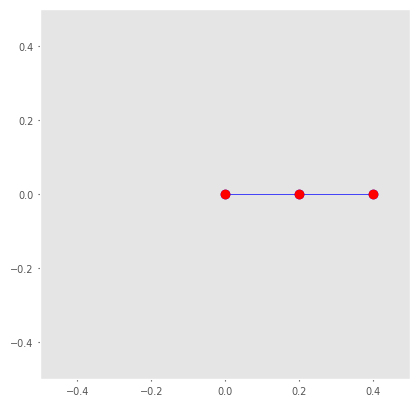

In [4]:
dp.show(set_qs=[0.0,0.0])

In [5]:
def generarRandomSamples(robot,N_samples=50000,show_histo=False):
  np.random.seed(42)            # Para reproducibilidad

  # Genero valores aleatorios para posición de los ejes y sus derivadas
  # 2 7 35
  q = 2*np.random.randn(N_samples, robot.nlinks)
  qd = 7*np.random.randn(N_samples, robot.nlinks)
  qdd = 35*np.random.randn(N_samples, robot.nlinks)

  tau = robot.rne(q,qd,qdd)

  if show_histo:
    num_features_X = 6
    for i in range(num_features_X):
        plt.subplot(3, 2, i + 1)
        plt.hist(X_back[:, i], bins=30, alpha=0.7, color='green', edgecolor='black')
        #plt.title(f'Histograma de X{i+1}')
        #plt.xlabel('Valor')
        #plt.ylabel('Frecuencia')
    plt.show()

    num_features_Y = 2
    for i in range(num_features_Y):
        plt.subplot(1, num_features_Y, i + 1)
        plt.hist(Y_back[:, i], bins=30, alpha=0.7, color='green', edgecolor='black')
        plt.title(f'Histograma de torques{i+1}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
    plt.show()
  return q,qd,qdd,tau


In [6]:
def generateRandomDataSet(robot,N_segments,flag_joint_move = False,flag_plot=False):
  """
  Genera un dataset para entrenamiento y pruebas

  Args:
    robot: Instancia del robot
    N_segments: Cantidad de puntos a visitar (fly by point). El movimiento empieza y termina con velocidad 0
    flag_joint_move: Indica si la secuencia de movimientos es joint o cartesiana
    flag_plot: Indica si se grafica la trayectoria deseada

  Returns:
    t_ref: Vector de tiempo de referencia
    q_ref: Vector de posiciones articulares de referencia
    qd_ref: Vector de velocidades articulares de referencia
    qdd_ref: Vector de aceleraciones articulares de referencia
    POSES_ref: Vector de posiciones cartesianas de referencia (Son las matrices A0_6 de cada posicion)
    tau_ref: Vector de torques de referencia calculado con la dinámica directa para realizar la trayectoria de referencia

  """
  alcanceXY = robot.a[0]+robot.a[1]
  Tj = np.random.rand(N_segments, )+0.5
  if flag_joint_move:
    q_dest = (np.random.rand(N_segments, 2)-0.5)*2*np.pi
    t_ref,q_ref,qd_ref,qdd_ref,POSES_ref = robot.genTrJoint(q_dest,Tj)
  else:
    # Limito las poses destino para trabajar en 2 cuadrantes y evitar pasar por singularidades
    POSE_dest = []
    while len(POSE_dest) < N_segments:
      x_dest = np.random.uniform(0, alcanceXY)
      y_dest = np.random.uniform(-alcanceXY, alcanceXY)
      if x_dest**2 + y_dest**2 < alcanceXY**2:
        POSE_dest.append(sm.SE3(x_dest, y_dest, 0))
    t_ref,q_ref,qd_ref,qdd_ref,POSES_ref = robot.genTrCart(POSE_dest,Tj)

  # Extraigo la posición del TCP para graficar
  pos_ref = np.vstack(([pose.t[0] for pose in POSES_ref], [pose.t[1] for pose in POSES_ref])).T

  # Obtengo la velocidad cartesiana derivando numéricamente
  posd_ref = np.diff(pos_ref, axis=0) / robot.Ts
  # Ajustar la longitud de qdd para que coincida con qd
  posd_ref = np.vstack([posd_ref, np.zeros(2,)])

  # Obtengo la aceleración cartesiana derivando numéricamente
  posdd_ref = np.diff(posd_ref, axis=0) / robot.Ts
  # Ajustar la longitud de qdd para que coincida con qd
  posdd_ref = np.vstack([posdd_ref, np.zeros(2,)])

  # Calculo con el PDI el torque para hacer esa trayectoria
  tau_ref = robot.rne(q_ref,qd_ref,qdd_ref)

  if flag_plot:
    # Muestro las variables joint deseadas
    plt.subplot(3,1,1)
    plt.plot(t_ref,q_ref)
    plt.legend(['q1', 'q2']);  plt.ylabel('q')
    plt.title('Variables articulares de referencia')
    plt.subplot(3,1,2)
    plt.plot(t_ref,qd_ref)
    plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
    plt.subplot(3,1,3)
    plt.plot(t_ref,qdd_ref)
    plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
    plt.show()

    # Muestro las variables cartesianas deseadas
    plt.subplot(3,1,1)
    plt.plot(t_ref,pos_ref)
    plt.legend(['x', 'y']);  plt.ylabel('Posición')
    plt.title('Variables cartesianas de referencia')
    plt.subplot(3,1,2)
    plt.plot(t_ref,posd_ref)
    plt.legend(['vx', 'vy']);  plt.ylabel('Velocidad')
    plt.subplot(3,1,3)
    plt.plot(t_ref,posdd_ref)
    plt.legend(['a1', 'a2']); plt.xlabel('Tiempo'); plt.ylabel('Aceleración')
    plt.show()

    # Muestro la trayectoria deseada
    fig,ax = plt.subplots()
    plt.plot(pos_ref[:,0],pos_ref[:,1])
    circle = Circle((0, 0), alcanceXY,edgecolor='b', facecolor='none', linestyle='--')
    ax.add_patch(circle)
    plt.xlabel('x'); plt.ylabel('y')
    plt.title(' Trayectoria de referencia')
    plt.axis('equal')
    plt.show()

    plt.plot(t_ref,tau_ref)
    plt.legend(['tau1', 'tau2']); plt.xlabel('Tiempo'); plt.ylabel('Torque')
    plt.title('Torque calculado para realizar trayectoria')
    plt.show()

  return t_ref,q_ref,qd_ref,qdd_ref,POSES_ref,tau_ref

In [7]:
def extraer_datos_a_file(nombre_archivo, cantidad, t_ref, q_ref, qd_ref, qdd_ref, tau_ref):
    # Verificar si el archivo existe y no está vacío

    if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
        # Si el archivo no existe o está vacío, escribir las cabeceras CSV
        with open(nombre_archivo, 'w') as archivo:
            archivo.write('ID, Time, Theta_1, Theta_2, D_Theta_1, D_Theta_2, DD_Theta_1, DD_Theta_2, Torque_1, Torque_2\n')
            #Length_1, Length_2, Alpha_1, Alpha_2 Mass_1, Mass_2, B_1, B_2, G_1, G_2
    with open(nombre_archivo, 'a') as archivo:
        for _ in range(cantidad):
            id = _ +1
            time = t_ref[_]
            j_1 = q_ref[_][0]
            j_2 = q_ref[_][1]
            d_j_1 = qd_ref[_][0]
            d_j_2 = qd_ref[_][1]
            dd_j_1 = qdd_ref[_][0]
            dd_j_2 = qdd_ref[_][1]
            tau_1 = tau_ref[_][0]
            tau_2 = tau_ref[_][1]

            archivo.write(f'{id}, {time}, {j_1}, {j_2}, {d_j_1}, {d_j_2}, {dd_j_1}, {dd_j_2}, {tau_1}, {tau_2}\n')

# Generación de Datos Randomizados #

Estos datos no están correlacionados, no responden a ninguna trayectoria determinada (estilo ruido blanco), se utilizarán para el entrenamiento de las redes FF.

In [8]:
n_samp_val = 300000
# Genero los datos
q_ref,qd_ref,qdd_ref,tau_ref = generarRandomSamples(dp,N_samples=n_samp_val,show_histo=False)

In [9]:
nombre_archivo = f'./2lpr_randomsamples_{fecha_actual}.csv'

cantidad = n_samp_val

if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
    # Si el archivo no existe o está vacío, escribir las cabeceras CSV
    with open(nombre_archivo, 'w') as archivo:
        archivo.write('ID, Theta_1, Theta_2, D_Theta_1, D_Theta_2, DD_Theta_1, DD_Theta_2, Torque_1, Torque_2\n')
        #Length_1, Length_2, Alpha_1, Alpha_2 Mass_1, Mass_2, B_1, B_2, G_1, G_2
with open(nombre_archivo, 'a') as archivo:
    for _ in range(cantidad):
        id = _ +1
        j_1 = q_ref[_][0]
        j_2 = q_ref[_][1]
        d_j_1 = qd_ref[_][0]
        d_j_2 = qd_ref[_][1]
        dd_j_1 = qdd_ref[_][0]
        dd_j_2 = qdd_ref[_][1]
        tau_1 = tau_ref[_][0]
        tau_2 = tau_ref[_][1]

        archivo.write(f'{id}, {j_1}, {j_2}, {d_j_1}, {d_j_2}, {dd_j_1}, {dd_j_2}, {tau_1}, {tau_2}\n')

# Generación de Trayectorias Joint #

Estos valores representan una trayectoria en el espacio de Joints, por lo que la secuencia implica una correlación entre las muestras. Utilizadas para el entrenamiento de redes LSTM. ¿Qué pasa con el One-Step Ahead approach?

/Users/melinagabrielacheminet/miniforge3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


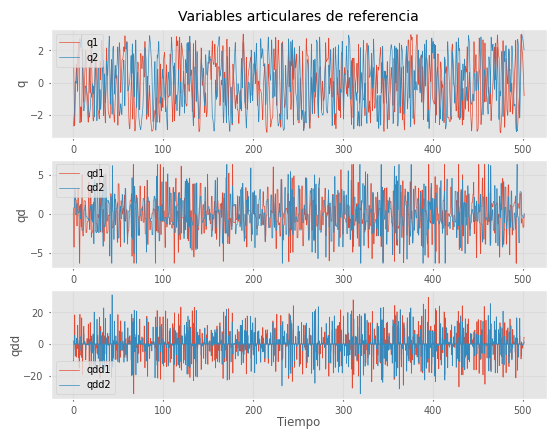

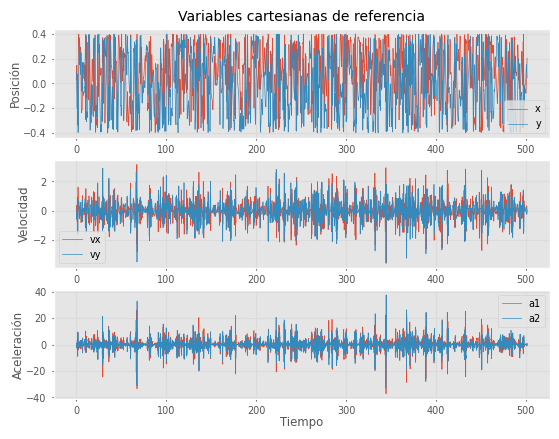

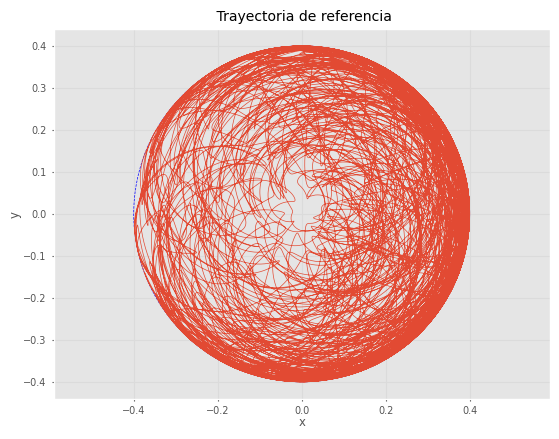

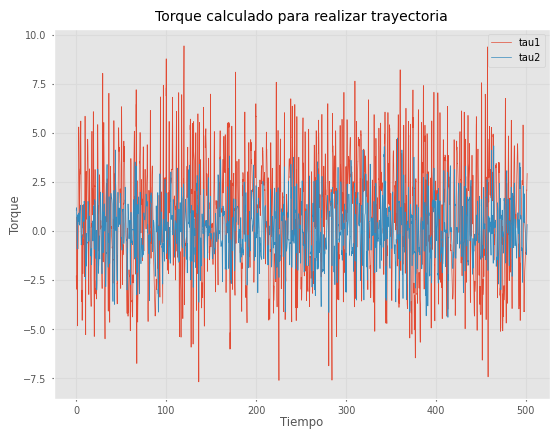

In [10]:
t_ref,q_ref,qd_ref,qdd_ref,POSES_ref,tau_ref = generateRandomDataSet(dp,500,flag_joint_move=True,flag_plot=True)

In [11]:
nombre_archivo = f'./2lpr_jointmovement_{fecha_actual}.csv'

cantidad = len(t_ref)
extraer_datos_a_file(nombre_archivo, cantidad, t_ref, q_ref, qd_ref, qdd_ref, tau_ref)

In [12]:
# Aumentar el límite de incrustación
plt.rcParams['animation.embed_limit'] = 70

In [13]:
#dp.show_animation(q_ref, 5)

# Generación de Trayectorias Cartesianas #

Estos valores representan una trayectoria en el espacio Cartesiano, por lo que la secuencia implica una correlación entre las muestras. Utilizadas para el entrenamiento de redes LSTM. ¿Qué pasa con el One-Step Ahead approach?

In [14]:
t_ref,q_ref,qd_ref,qdd_ref,POSES_ref,tau_ref = generateRandomDataSet(dp,500,flag_joint_move=False,flag_plot=True)

IndexError: index 499 is out of bounds for axis 1 with size 400

In [ ]:
#dp.show_animation(q_ref, 10)

In [ ]:
nombre_archivo = f'./2lpr_cartesianmovement_{fecha_actual}.csv'
cantidad = len(t_ref)
extraer_datos_a_file(nombre_archivo, cantidad, t_ref, q_ref, qd_ref, qdd_ref, tau_ref)

# Forzando señales de Torque en Joints #

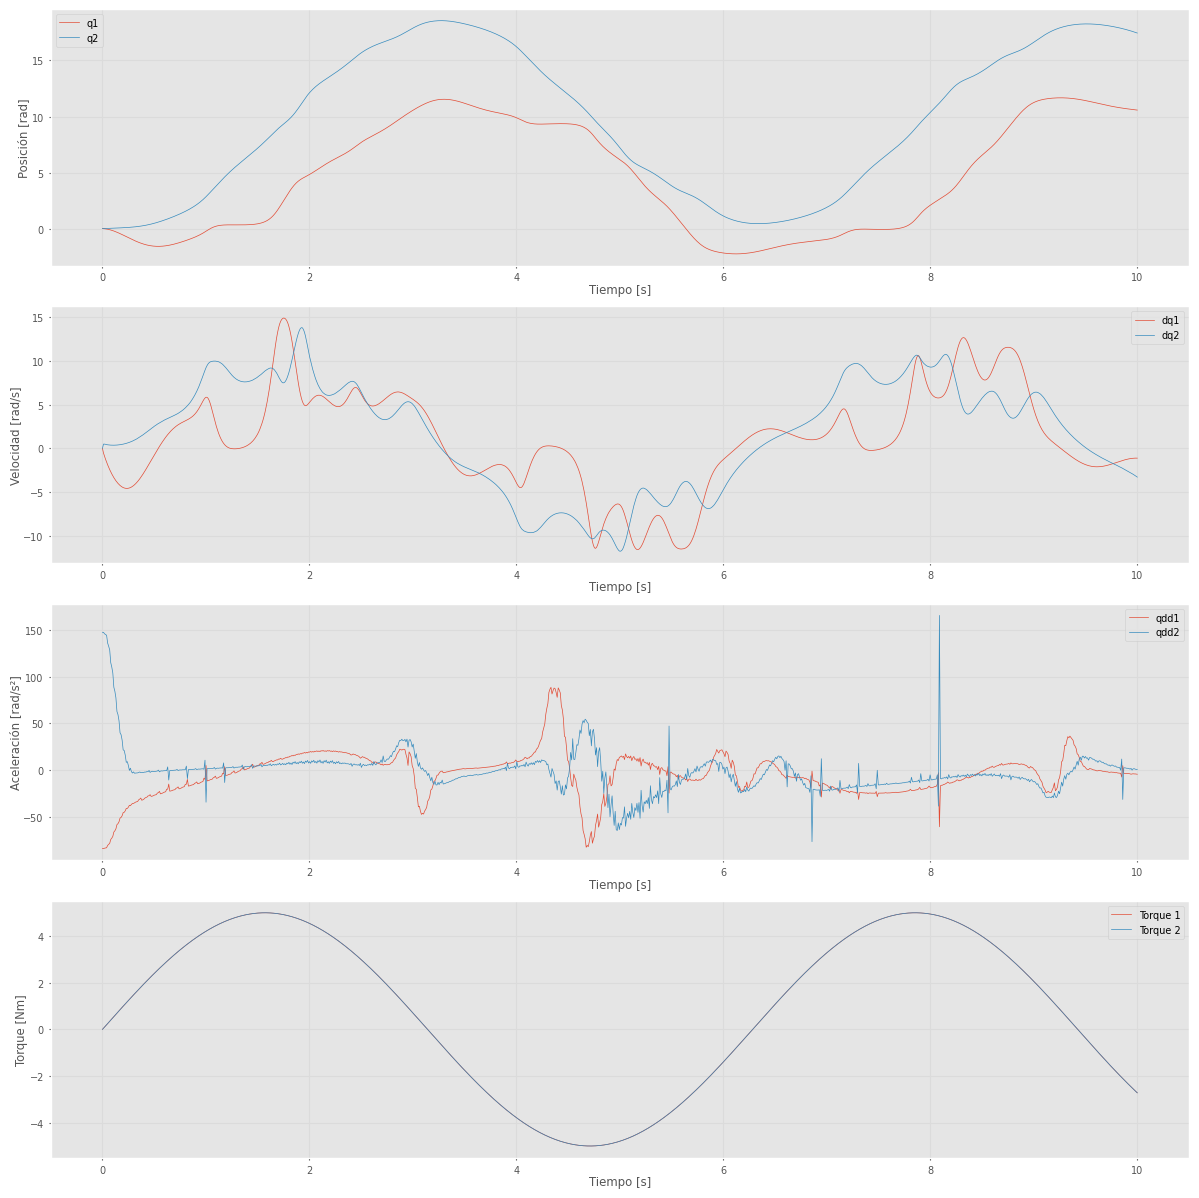

In [ ]:
# Definir la función de torques en el tiempo
def applied_torques(t):
    #return np.array([0.0, 0.0])
    return np.array([5*np.sin(t), 5*np.sin(t)])

# Lista para almacenar las aceleraciones
qdds_list = []

# Definir la función de dinámica del sistema
def dynamics(t, y):
    qs = y[:2].reshape(1, -1)  # Reshape para tener forma (1, 2)
    dqs = y[2:].reshape(1, -1)  # Reshape para tener forma (1, 2)
    torques = applied_torques(t).reshape(1, -1)  # Reshape para tener forma (1, 2)
    qdds = dp.nofriction().accel(qs, dqs, torques)
    qdds = dp.accel(qs, dqs, torques)
    qdds_list.append(qdds.ravel())  # Almacenar qdds como un vector
    return np.concatenate([dqs.ravel(), qdds.ravel()])

# Condiciones iniciales
starting_qs = np.array([0.0, 0.0])
starting_dqs = np.array([0.0, 0.0])
y0 = np.concatenate([starting_qs, starting_dqs])

# Intervalo de tiempo para la simulación
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Limpiar la lista de aceleraciones antes de ejecutar la simulación
qdds_list = []

# Resolver la ecuación diferencial
sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, method='RK23')


# Convertir qdds_list a un array de numpy
qdds = np.array(qdds_list).T

# Extraer las soluciones
qs = sol.y[:2, :]
dqs = sol.y[2:, :]

# Calcular los torques para cada punto en el tiempo
torques = np.array([applied_torques(ti) for ti in t_eval])

# Graficar los resultados
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.plot(sol.t, qs[0, :], label='q1')
plt.plot(sol.t, qs[1, :], label='q2')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [rad]')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sol.t, dqs[0, :], label='dq1')
plt.plot(sol.t, dqs[1, :], label='dq2')
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [rad/s]')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sol.t, qdds[0, :len(sol.t)], label='qdd1')  # Asegúrate de que las dimensiones coincidan
plt.plot(sol.t, qdds[1, :len(sol.t)], label='qdd2')  # Asegúrate de que las dimensiones coincidan
plt.xlabel('Tiempo [s]')
plt.ylabel('Aceleración [rad/s²]')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sol.t, torques[:, 0], label='Torque 1')
plt.plot(sol.t, torques[:, 1], label='Torque 2')
plt.xlabel('Tiempo [s]')
plt.ylabel('Torque [Nm]')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#dp.show_animation(qs.T, 10)

In [ ]:
dp.links[0].I

array([[0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.001]])

In [ ]:
signal_type = 'sinusoidal'

nombre_archivo = f'./2lpr_forcedtorques_{signal_type}_{fecha_actual}.csv'

cantidad = len(t_eval)

if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
    # Si el archivo no existe o está vacío, escribir las cabeceras CSV
    with open(nombre_archivo, 'w') as archivo:
        archivo.write('ID, Time, Theta_1, Theta_2, D_Theta_1, D_Theta_2, DD_Theta_1, DD_Theta_2, Torque_1, Torque_2\n')
        #Length_1, Length_2, Alpha_1, Alpha_2 Mass_1, Mass_2, B_1, B_2, G_1, G_2
with open(nombre_archivo, 'a') as archivo:
    for _ in range(cantidad):
        id = _ +1
        time = t_eval[_]
        j_1 = qs.T[_][0]
        j_2 = qs.T[_][1]
        d_j_1 = dqs.T[_][0]
        d_j_2 = dqs.T[_][1]
        dd_j_1 = qdds.T[_][0]
        dd_j_2 = qdds.T[_][1]
        tau_1 = torques[_][0]
        tau_2 = torques[_][1]
        #link1_a = dp.links[0].a
        #link2_a = dp.links[1].a
        #link1_alpha = dp.links[0].alpha
        #link2_alpha = dp.links[2].alpha
        #link1_m = dp.links[0].m
        #link2_m = dp.links[1].m
        #link1_B = dp.links[0].B
        #link2_B = dp.links[1].B
        #link1_G = dp.links[0].G
        #link2_G = dp.links[1].G

        archivo.write(f'{id}, {time}, {j_1}, {j_2}, {d_j_1}, {d_j_2}, {dd_j_1}, {dd_j_2}, {tau_1}, {tau_2}\n')

In [ ]:
import numpy as np

# Definir la ley de control (un controlador PD simple)
def control_law(robot, t, q, qd):
    Kp = np.array([100, 100])  # Ganancias proporcionales
    Kd = np.array([10, 10])    # Ganancias derivativas
    q_desired = np.array([0.0, 0.0])  # Posición deseada
    qd_desired = np.array([0.0, 0.0]) # Velocidad deseada
    
    # Ley de control PD
    tau = Kp * (q_desired - q) + Kd * (qd_desired - qd)
    return tau

# Condiciones iniciales
q0 = np.array([0.1, 0.2])  # Posiciones iniciales
qd0 = np.array([0.0, 0.0])   # Velocidades iniciales
tfinal = 5.0  # Tiempo de simulación

# Ejecutar la simulación
sol = dp.nofriction().fdyn(tfinal, q0, control_law)

# Acceder a la solución
q = sol.q        # Posiciones articulares a lo largo del tiempo
qd = sol.qd      # Velocidades articulares a lo largo del tiempo

# Calcular las aceleraciones articulares manualmente usando diferencias finitas
dt = sol.t[1] - sol.t[0]
qdd = np.gradient(qd, dt, axis=0)

# Acceder a los torques aplicados si están disponibles
tau = control_law(dp, sol.t, q, qd)

# Mostrar los resultados
print("Posiciones (q):", q)
print("Velocidades (qd):", qd)
print("Aceleraciones (qdd):", qdd)
print("Torques (tau):", tau)


Posiciones (q): [[ 0.1         0.2       ]
 [ 0.1         0.2       ]
 [ 0.1         0.19999999]
 ...
 [-0.04405252 -0.0097858 ]
 [-0.04405252 -0.0097858 ]
 [-0.04405252 -0.0097858 ]]
Velocidades (qd): [[ 0.00000000e+00  0.00000000e+00]
 [ 3.66460495e-04 -1.35435202e-03]
 [ 4.01118702e-03 -1.48300966e-02]
 ...
 [-2.00680382e-07  6.80637580e-07]
 [-2.64935065e-07  8.98566965e-07]
 [-5.25924567e-08  1.78375196e-07]]
Aceleraciones (qdd): [[ 2.08206681e+03 -7.69483047e+03]
 [ 1.13948972e+04 -4.21290322e+04]
 [ 1.08432734e+05 -4.02481798e+05]
 ...
 [ 1.16628510e-01 -3.95563066e-01]
 [ 4.20685118e-01 -1.42681661e+00]
 [ 1.20643699e+00 -4.09181180e+00]]
Torques (tau): [[-10.         -20.        ]
 [-10.00366461 -19.98645647]
 [-10.04011226 -19.8516976 ]
 ...
 [  4.40525442   0.97857325]
 [  4.40525506   0.97857108]
 [  4.40525294   0.97857827]]


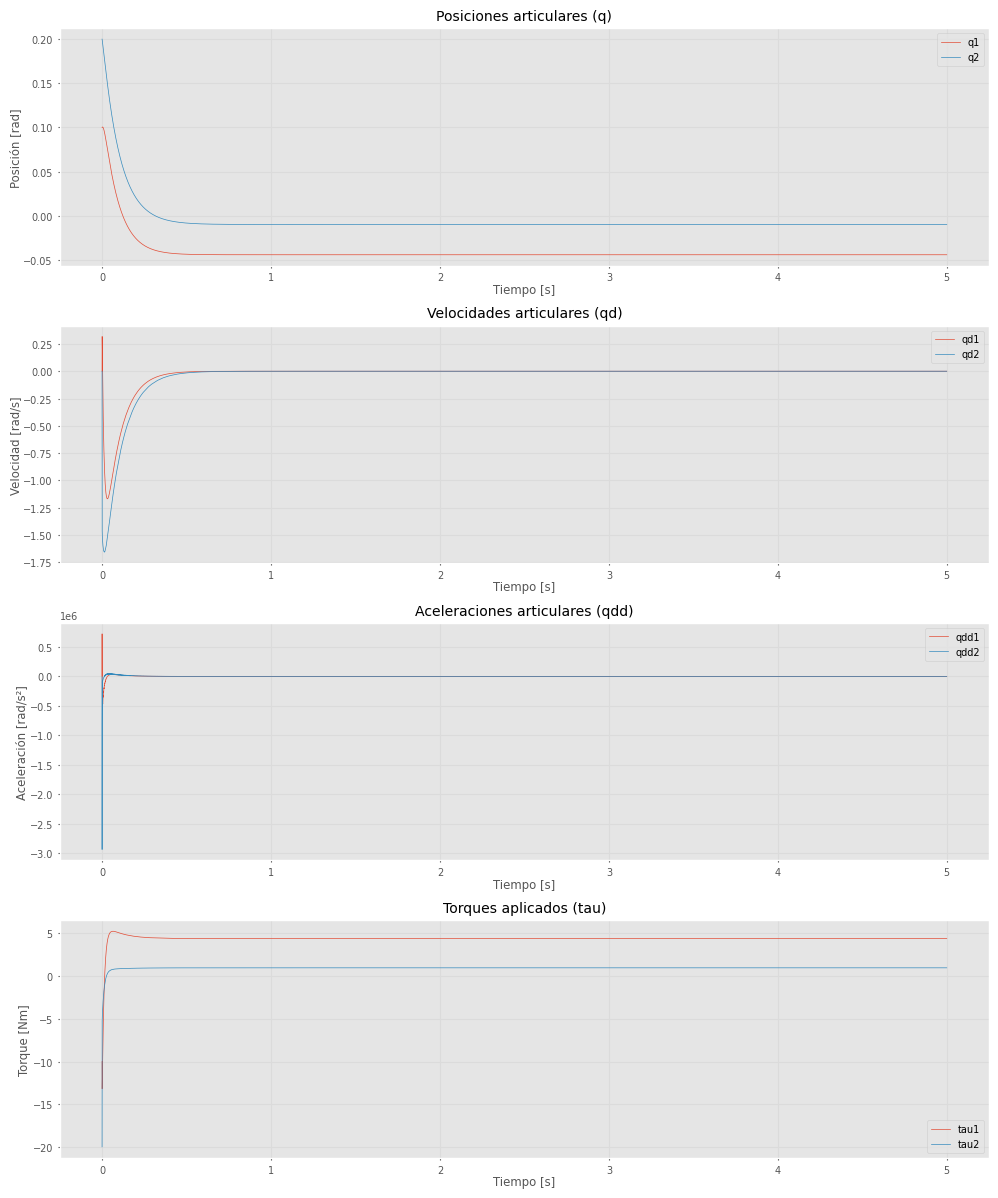

In [ ]:
# Supongamos que 'sol.t' es el vector de tiempo
time = sol.t
# Crear una figura con subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12))

# Graficar posiciones articulares q
axs[0].plot(time, q)
axs[0].set_title('Posiciones articulares (q)')
axs[0].set_xlabel('Tiempo [s]')
axs[0].set_ylabel('Posición [rad]')
axs[0].legend(['q1', 'q2'])

# Graficar velocidades articulares qd
axs[1].plot(time, qd)
axs[1].set_title('Velocidades articulares (qd)')
axs[1].set_xlabel('Tiempo [s]')
axs[1].set_ylabel('Velocidad [rad/s]')
axs[1].legend(['qd1', 'qd2'])

# Graficar aceleraciones articulares qdd
axs[2].plot(time, qdd)
axs[2].set_title('Aceleraciones articulares (qdd)')
axs[2].set_xlabel('Tiempo [s]')
axs[2].set_ylabel('Aceleración [rad/s²]')
axs[2].legend(['qdd1', 'qdd2'])

# Graficar torques aplicados tau
axs[3].plot(time, tau)
axs[3].set_title('Torques aplicados (tau)')
axs[3].set_xlabel('Tiempo [s]')
axs[3].set_ylabel('Torque [Nm]')
axs[3].legend(['tau1', 'tau2'])

# Ajustar los espaciados entre los subplots
plt.tight_layout()
plt.show()